In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import pathlib
import glob
import shutil
import os
import random

In [2]:
#--------------------------------caution: terminal commands ---------------------------------------------
%cd
%cd .keras/datasets/
!rm -r *

/root
[Errno 2] No such file or directory: '.keras/datasets/'
/root
rm: cannot remove '*': No such file or directory


In [3]:
########################################### download data from given url ###############################################

dataset_url = "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"
data_dir = tf.keras.utils.get_file('dakshina_dataset_v1.0', origin=dataset_url, untar=True)

2008342528/2008340480 [==============================] - 17s 0us/step


In [4]:
#----------------------------------terminal command -----------------------------------------------
%cd /root/.keras/datasets/dakshina_dataset_v1.0/hi/lexicons/
!ls

/root/.keras/datasets/dakshina_dataset_v1.0/hi/lexicons
hi.translit.sampled.dev.tsv   hi.translit.sampled.train.tsv
hi.translit.sampled.test.tsv


In [5]:
train_data_path = "hi.translit.sampled.train.tsv"
test_data_path = "hi.translit.sampled.test.tsv"
validation_data_path = "hi.translit.sampled.dev.tsv"

**UTILITY FUNCTION FOR DATA PRE-PROCESSING**

In [6]:
################################################ preparing the data in required format #################################################

def data(path,input_token_index,target_token_index):
  input_texts = []
  target_texts = []
  with open(path, "r", encoding="utf-8") as f:
      lines = f.read().split("\n")
  del lines[-1]
  for line in lines:
      target_text, input_text, _ = line.split("\t")

      input_text = "\t"+input_text + "\n"
      target_text = "\t"+target_text + "\n"

      input_texts.append(input_text)
      target_texts.append(target_text)

  encoder_input_data = np.zeros( (len(input_texts), max_encoder_seq_length), dtype="int32")
  decoder_input_data = np.zeros( (len(input_texts), max_decoder_seq_length), dtype="int32")
  decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="int32")

  for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
      for t, char in enumerate(input_text):
          encoder_input_data[i, t] = input_token_index[char]
      encoder_input_data[i, t + 1 :] = input_token_index[" "]
      for t, char in enumerate(target_text):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[char]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
      decoder_input_data[i, t + 1 :] = target_token_index[" "]
      decoder_target_data[i, t:, target_token_index[" "]] = 1.0
    
  return (encoder_input_data, decoder_input_data, decoder_target_data, target_texts, input_texts)

**PREPROCESSING THE DATA**

In [7]:
################################################ preprocessing the train data and getting dictionaries #################################################

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(train_data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

del lines[-1]
for line in lines:
    target_text, input_text, _ = line.split("\t")
    input_text = "\t"+input_text + "\n"
    target_text = "\t"+target_text + "\n"

    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters.add(" ")
target_characters.add(" ")

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])


Number of samples: 44204
Number of unique input tokens: 29
Number of unique output tokens: 66
Max sequence length for inputs: 22
Max sequence length for outputs: 21



**MACHINE TRANSLITERATOR**


In [95]:
class Machine_Transliterator():

  ############################################# constructor for class Machine_Transliterator ##########################################

  def __init__(self,max_encoder_seq_length,max_decoder_seq_length,encoder_embed_size, decoder_embed_size,
               num_encoder_layers,num_decoder_layers,epochs, hidden_layer_size,
               num_encoder_tokens, cell_type, num_decoder_tokens,input_token_index, target_token_index, 
               activation="softmax",optimizer="rmsprop",dropout=0.05):
    
    self.cell_type= cell_type
    self.hidden_layer_size = hidden_layer_size  
    self.optimizer = optimizer
    self.activation = activation   
    self.dropout=dropout

    #-------------------------------------- Number of hidden layers -------------------------------------

    self.num_encoder_layers = num_encoder_layers
    self.num_decoder_layers=num_decoder_layers

    #-------------------------------------- sequence length -------------------------------------
    self.max_decoder_seq_length=max_decoder_seq_length
    self.max_encoder_seq_length=max_encoder_seq_length

    #---------------------------------------------Embedding size-------------------------------------
    self.encoder_embed_size = encoder_embed_size
    self.decoder_embed_size = decoder_embed_size
    
    #-----------------information obtained after preprocessing of data-------------------------------------
    self.num_encoder_tokens = num_encoder_tokens
    self.num_decoder_tokens = num_decoder_tokens

    #-----------------------------dictionaries----------------------------------------------------
    self.input_token_index = input_token_index
    self.target_token_index = target_token_index

 


#########################################function to build model ###########################################

  def build_model(self):

    
    encoder_inputs = keras.Input(shape=(None,))  
    # encoder_inputs = keras.Input(shape=(self.max_encoder_seq_length,)) 
    # encoder_embedding_output = tf.keras.layers.Embedding(self.num_encoder_tokens, self.encoder_embed_size)(encoder_inputs)
    encoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_encoder_tokens, output_dim = self.encoder_embed_size, name = "encoder_embedding_layer")(encoder_inputs)


#------------------------------ if cell type = LSTM -------------------------------------------------------------
    if self.cell_type == "lstm":
     #--------------------- encoder -----------------------------------
      encoder = keras.layers.LSTM(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = "encoder_layer_0")
      encoder_outputs, state_h, state_c = encoder(encoder_embedding_output)
      for i in range(1,self.num_encoder_layers):
        encoder = keras.layers.LSTM(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = ("encoder_layer_"+ str(i) ) )
        encoder_outputs, state_h, state_c = encoder(encoder_outputs)
      encoder_states = [state_h, state_c]

      #---------------------------decoder ---------------------------------------------------
      decoder_inputs = keras.Input(shape=(None, )) 
      # decoder_inputs = keras.Input(shape=(self.max_decoder_seq_length, ))      
      # decoder_embedding_output = tf.keras.layers.Embedding(self.num_decoder_tokens, self.decoder_embed_size)(decoder_inputs)
      decoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_decoder_tokens, output_dim = self.decoder_embed_size, name = "decoder_embedding_layer")(decoder_inputs)

      decoder = keras.layers.LSTM(self.hidden_layer_size, return_sequences=True, return_state=True,dropout=self.dropout,use_bias=True, name = "decoder_layer_0")
      decoder_outputs, _, _= decoder(decoder_embedding_output, initial_state = encoder_states)
      for i in range(1,self.num_decoder_layers):
        decoder = keras.layers.LSTM(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = ("decoder_layer_"+ str(i) ) )
        decoder_outputs, _ , _= decoder(decoder_outputs, initial_state = encoder_states)



#------------------------------ if cell type = Simple RNN -------------------------------------------------------------
    elif self.cell_type == "rnn":
      #--------------------- encoder -----------------------------------
      encoder = keras.layers.SimpleRNN(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout, use_bias=True, name = "encoder_layer_0")
      encoder_outputs, state = encoder(encoder_embedding_output)
      for i in range(1,self.num_encoder_layers):
        encoder = keras.layers.SimpleRNN(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout, use_bias=True, name = ("encoder_layer_"+ str(i) ))
        encoder_outputs, state = encoder(encoder_outputs)
      encoder_states = [state]

      #---------------------------decoder ---------------------------------------------------
      decoder_inputs = keras.Input(shape=(None, ))      
      # decoder_embedding_output = tf.keras.layers.Embedding(self.num_decoder_tokens, self.decoder_embed_size)(decoder_inputs)
      decoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_decoder_tokens, output_dim = self.decoder_embed_size, name = "decoder_embedding_layer")(decoder_inputs)

      decoder = keras.layers.SimpleRNN(self.hidden_layer_size, return_state=True,return_sequences=True, dropout=self.dropout, use_bias=True, name = "decoder_layer_0")
      decoder_outputs, _ = decoder(decoder_embedding_output, initial_state = encoder_states)
      for i in range(1,self.num_decoder_layers):
        decoder = keras.layers.SimpleRNN(self.hidden_layer_size, return_state=True,return_sequences=True, dropout=self.dropout, use_bias=True, name = ("decoder_layer_"+ str(i) ))
        decoder_outputs, _= decoder(decoder_outputs, initial_state = encoder_states)



#------------------------------ if cell type = GRU -------------------------------------------------------------
    elif self.cell_type == "gru":
      #--------------------- encoder -----------------------------------
      encoder = keras.layers.GRU(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = "encoder_layer_0")
      encoder_outputs, state = encoder(encoder_embedding_output)
      for i in range(1,self.num_encoder_layers):
        encoder = keras.layers.GRU(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = ("encoder_layer_"+ str(i) ))
        encoder_outputs, state = encoder(encoder_outputs)
      encoder_states = [state]

      #---------------------------decoder ---------------------------------------------------
      decoder_inputs = keras.Input(shape=(None, ))      
      # decoder_embedding_output = tf.keras.layers.Embedding(self.num_decoder_tokens, self.decoder_embed_size)(decoder_inputs)
      decoder_embedding_output = tf.keras.layers.Embedding(input_dim = self.num_decoder_tokens, output_dim = self.decoder_embed_size, name = "decoder_embedding_layer")(decoder_inputs)
      
      decoder = keras.layers.GRU(self.hidden_layer_size, return_state=True,return_sequences=True, dropout=self.dropout,use_bias=True, name = "decoder_layer_0")
      decoder_outputs, _ = decoder(decoder_embedding_output, initial_state = encoder_states)
      for i in range(1,self.num_decoder_layers):
        decoder = keras.layers.GRU(self.hidden_layer_size, return_state=True,return_sequences=True,dropout=self.dropout,use_bias=True, name = ("decoder_layer_"+ str(i) ))
        decoder_outputs, _ = decoder(decoder_outputs, initial_state = encoder_states)


    decoder_dense = keras.layers.Dense(self.num_decoder_tokens, activation = self.activation,use_bias=True, name = "dense")
    decoder_outputs = decoder_dense(decoder_outputs)
    model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    #-----------------compile the model -------------------------------------
    model.compile(
         optimizer=self.optimizer,
         loss="categorical_crossentropy",
         metrics=["accuracy"]
         ) 

#-------------------------- return final model ---------------------------------------------------------
    return model





#########################################function for training the model ###########################################

  def train_model(self,encoder_input_data,decoder_input_data,decoder_target_data,epochs,batch_size,
                  val_encoder_input_data, val_decoder_input_data, val_decoder_target_data):
    
     model=self.build_model()
  
     model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = ([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data),
        # callbacks=[WandbCallback()]
        )
     return model

#########################################function for inference on the model ###########################################

  def sampling_inference(self, model, num_encoder_layers, num_decoder_layers):
     
     # Initialsiations
     encoder_model = None
     decoder_model = None

     

     #--------------------------------------if cell type = LSTM ----------------------------------------------------------
     if self.cell_type =="lstm":

        #  for i in range(0, num_encoder_layers):
        #    encoder_outputs, state_h_enc, state_c_enc = model.layers[i].output  # lstm_1

        #-----------------------------------encoder layers-------------------------------------

        #constants
        e_inputs = model.input[0]  # input_1
        e_embed_layer = model.get_layer("encoder_embedding_layer")
        encoder_inputs = e_embed_layer(e_inputs)

        #encoder cell layers
        encoder_cell = None
        for i in range(0, num_encoder_layers-1):
          encoder_cell = model.get_layer("encoder_layer_" + str(i))
          encoder_inputs, _, _ = encoder_cell(encoder_inputs)
        encoder_cell = model.get_layer("encoder_layer_" + str(num_encoder_layers-1))
        encoder_outputs, state_h_enc, state_c_enc = encoder_cell(encoder_inputs)
        encoder_states = [state_h_enc, state_c_enc]

        #encoder model
        encoder_model = keras.Model(e_inputs, encoder_states)

        #-----------------------------------decoder layers-------------------------------------

        #constants
        d_inputs = model.input[1] #input_2
        d_embed_layer = model.get_layer("decoder_embedding_layer")
        decoder_inputs = d_embed_layer(d_inputs)
        decoder_state_input_h = keras.Input(shape=(self.hidden_layer_size,), name="input_decoder_h")
        decoder_state_input_c = keras.Input(shape=(self.hidden_layer_size,), name="input_decoder_c")
        decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

        #decoder cell layers
        decoder_cell = None
        for i in range(0, num_decoder_layers-1):
          decoder_cell = model.get_layer("decoder_layer_" + str(i))
          decoder_inputs, _, _ = decoder_cell(decoder_inputs, initial_state = decoder_state_inputs)
        decoder_cell = model.get_layer("decoder_layer_" + str(num_decoder_layers-1))
        decoder_inputs, state_h_dec, state_c_dec = decoder_cell(decoder_inputs, initial_state = decoder_state_inputs)
        decoder_states = [state_h_dec, state_c_dec]

        #dense layer and decoder model     
        decoder_dense = model.get_layer("dense")
        decoder_outputs = decoder_dense(decoder_inputs)
        decoder_model = keras.Model([d_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)


     #-------------------------------------if cell type =Simple RNN or GRU---------------------------------------------
     elif self.cell_type =="rnn" or self.cell_type =="gru":

        #-----------------------------------encoder layers-------------------------------------
        #constants
        e_inputs = model.input[0]  # input_1
        e_embed_layer = model.get_layer("encoder_embedding_layer")
        encoder_inputs = e_embed_layer(e_inputs)

        #encoder cell layers
        encoder_cell = None
        for i in range(0, num_encoder_layers-1):
          encoder_cell = model.get_layer("encoder_layer_" + str(i))
          encoder_inputs, _ = encoder_cell(encoder_inputs)
        encoder_cell = model.get_layer("encoder_layer_" + str(num_encoder_layers-1))
        encoder_outputs, state_h_enc = encoder_cell(encoder_inputs)
        encoder_states = [state_h_enc]

        #encoder model
        encoder_model = keras.Model(e_inputs, encoder_states)

        #-----------------------------------decoder layers-------------------------------------

        #constants
        d_inputs = model.input[1] #input_2
        d_embed_layer = model.get_layer("decoder_embedding_layer")
        decoder_inputs = d_embed_layer(d_inputs)
        decoder_state_input_h = keras.Input(shape=(self.hidden_layer_size,), name="input_decoder_h")
        decoder_state_inputs = [decoder_state_input_h]

        #decoder cell layers
        decoder_cell = None
        for i in range(0, num_decoder_layers-1):
          decoder_cell = model.get_layer("decoder_layer_"+str(i))
          decoder_inputs, _ = decoder_cell(decoder_inputs, initial_state = decoder_state_inputs)
        decoder_cell = model.get_layer("decoder_layer_" + str(num_decoder_layers-1))
        decoder_inputs, state_h_dec = decoder_cell(decoder_inputs, initial_state = decoder_state_inputs)
        decoder_states = [state_h_dec]

        #dense layer and decoder model        
        decoder_dense = model.get_layer("dense")
        decoder_outputs = decoder_dense(decoder_inputs)
        decoder_model = keras.Model([d_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

     reverse_input_char_index = dict((i, char) for char, i in self.input_token_index.items())
     reverse_target_char_index = dict((i, char) for char, i in self.target_token_index.items())
     return (reverse_input_char_index,reverse_target_char_index, encoder_model, decoder_model)



##################################################function for decoding input sequence ###########################################

  def decode_sequence(self, input_data, encoder_model, decoder_model, max_decoder_seq_length, target_token_index):

    num_examples = input_data.shape[0]
    max_encoder_seq_length = input_data.shape[0]

    # raw form of predictions to be returned
    predicted_output = np.full((num_examples, max_decoder_seq_length), target_token_index[" "])

    # ------ -----------if cell type=LSTM ---------------------------------
    if self.cell_type =="lstm":
      states_value = encoder_model.predict(input_data[:num_examples,:])
      target_seq = np.zeros((num_examples, 1),dtype="int32")
      target_seq[:, 0] = self.target_token_index["\t"]  

    # ------ -----------if cell type= Simple RNN or GRU --------------------
    elif self.cell_type == "rnn" or self.cell_type =="gru":
      states_value = (encoder_model.predict(input_data[:num_examples,:]))
      target_seq = np.zeros((num_examples, 1),dtype="int32")
      target_seq[:, 0] = self.target_token_index["\t"]  

    for i in range(max_decoder_seq_length):
      # ------------------if cell type=LSTM ---------------------------------
      if self.cell_type =="lstm":
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        states_value = [h, c]
      # ------------------if cell type= Simple RNN or GRU --------------------
      elif self.cell_type =="rnn" or self.cell_type =="gru":
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        states_value = [h] 

      for j in range(num_examples):
        target_seq[j,0] = np.argmax(output_tokens[j, -1, :])
        if target_seq[j,0] == target_token_index["\n"]:
          predicted_output[j,i] = target_token_index[" "]
        else:
          predicted_output[j,i] = target_seq[j,0]

  #--------------------------- return predictions ------------------------------
    return predicted_output
  
  ##################################################function for calculating accuracy ###########################################

  def calculate_accuracy(self, output_corpus, input_data, reverse_target_char_index, encoder_model, decoder_model):
    
    limit = input_data.shape[0]   

    ########################### creating vectorised form of true output ###############################
    true_output = np.full((limit, self.max_decoder_seq_length), self.target_token_index[" "])
    for row in range(limit):
      example = output_corpus[row].replace("\n","").replace("\t","")
      for col in range(len(example)):
        true_output[row][col] = self.target_token_index[example[col]]
    
    ########################### creating vectorised form of predicted output ###############################
    predicted_output = self.decode_sequence(input_data, encoder_model, decoder_model, self.max_decoder_seq_length, target_token_index)

    ########################### calculating accuracy ###############################
    A = true_output
    B = predicted_output 
    accuracy = (np.count_nonzero((A == B).all(1))/A.shape[0])

    return accuracy

#===================================== end of class Machine_Transliterator ==========================================



**PARAMETERS**

In [96]:
cell_type = "gru" # Type of the recurring unit
batch_size = 64  # Batch size for training.
epochs = 30  # Number of epochs to train for.
hidden_layer_size= 56  # Latent dimensionality of the encoding space.
# num_samples = 10000  # Number of samples to train on.
activation = "softmax" #activation
optimizer = "Adam"  #optimizer
encoder_embed_size = 32 #Encoder embedsize
decoder_embed_size = 32 #Decoder embedsize
num_encoder_layers=1  # number of hidden layers in encoder
num_decoder_layers=1   # number of hidden layers in decoder
dropout=0.0 #Dropout

**PREPROCESSING THE DATA**

In [97]:
############################# preprocessing the data ################################

(encoder_input_data,decoder_input_data,decoder_target_data, _, _)=data(train_data_path,input_token_index,target_token_index)
(val_encoder_input_data,val_decoder_input_data,val_decoder_target_data, val_target_texts, val_input_texts)=data(validation_data_path ,input_token_index,target_token_index)

In [98]:
(t_encoder_input_data,t_decoder_input_data,t_decoder_target_data, t_target_texts, t_input_texts)=data(test_data_path ,input_token_index,target_token_index)

**CREATING MACHINE TRANSLITERATOR**

In [99]:
########################### creating machine transliterator object ###############################
machine = Machine_Transliterator(
      max_encoder_seq_length,max_decoder_seq_length,encoder_embed_size, 
      decoder_embed_size,num_encoder_layers,num_decoder_layers,
      batch_size, hidden_layer_size, num_encoder_tokens, cell_type, num_decoder_tokens, 
      input_token_index,target_token_index, activation, optimizer,dropout
    )

**TRAINING**

In [100]:
model = machine.train_model(
    encoder_input_data, decoder_input_data,decoder_target_data,epochs,batch_size,
    val_encoder_input_data, val_decoder_input_data, val_decoder_target_data
    )

Epoch 1/30
691/691 [==============================] - 9s 8ms/step - loss: 1.6962 - accuracy: 0.6748 - val_loss: 0.9084 - val_accuracy: 0.7539
Epoch 2/30
691/691 [==============================] - 5s 7ms/step - loss: 0.9240 - accuracy: 0.7498 - val_loss: 0.8537 - val_accuracy: 0.7648
Epoch 3/30
691/691 [==============================] - 5s 7ms/step - loss: 0.8781 - accuracy: 0.7602 - val_loss: 0.8262 - val_accuracy: 0.7710
Epoch 4/30
691/691 [==============================] - 5s 7ms/step - loss: 0.8533 - accuracy: 0.7656 - val_loss: 0.8104 - val_accuracy: 0.7734
Epoch 5/30
691/691 [==============================] - 5s 7ms/step - loss: 0.8336 - accuracy: 0.7692 - val_loss: 0.7944 - val_accuracy: 0.7771
Epoch 6/30
691/691 [==============================] - 5s 7ms/step - loss: 0.8146 - accuracy: 0.7730 - val_loss: 0.7694 - val_accuracy: 0.7831
Epoch 7/30
691/691 [==============================] - 5s 7ms/step - loss: 0.7795 - accuracy: 0.7815 - val_loss: 0.7383 - val_accuracy: 0.7891
Epoch 

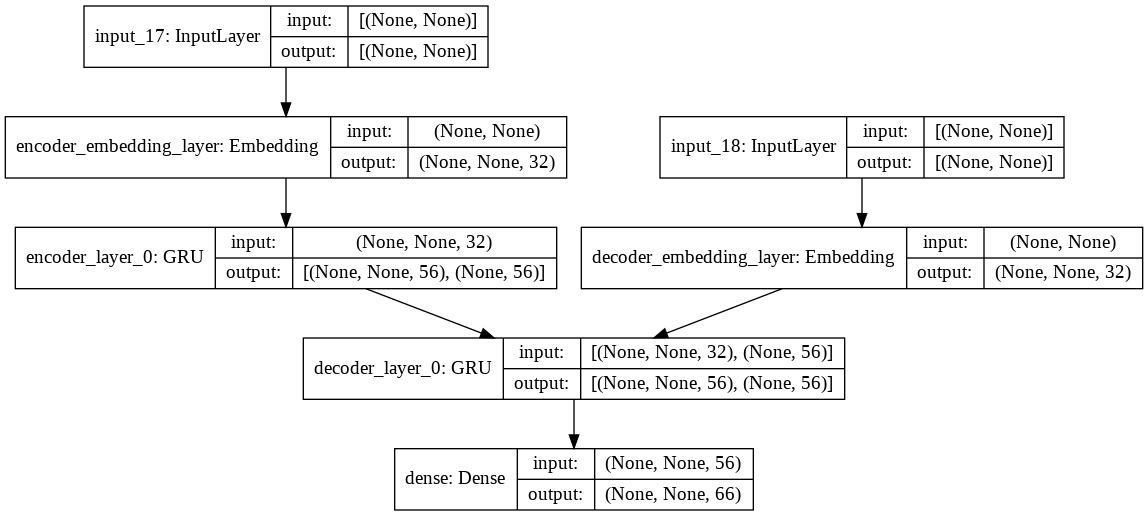

In [106]:
tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=True)

**INFERENCE**

In [102]:
(reverse_input_char_index,reverse_target_char_index, encoder_model, decoder_model) = machine.sampling_inference(model, num_encoder_layers, num_decoder_layers)

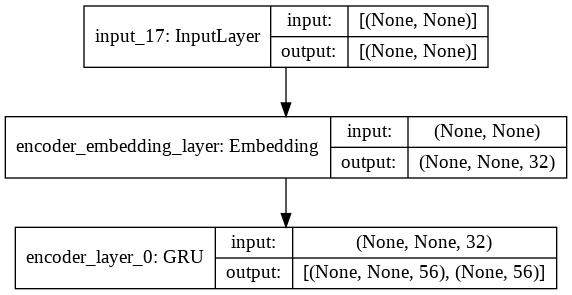

In [107]:
tf.keras.utils.plot_model(encoder_model, to_file = "encoder.png", show_shapes=True)

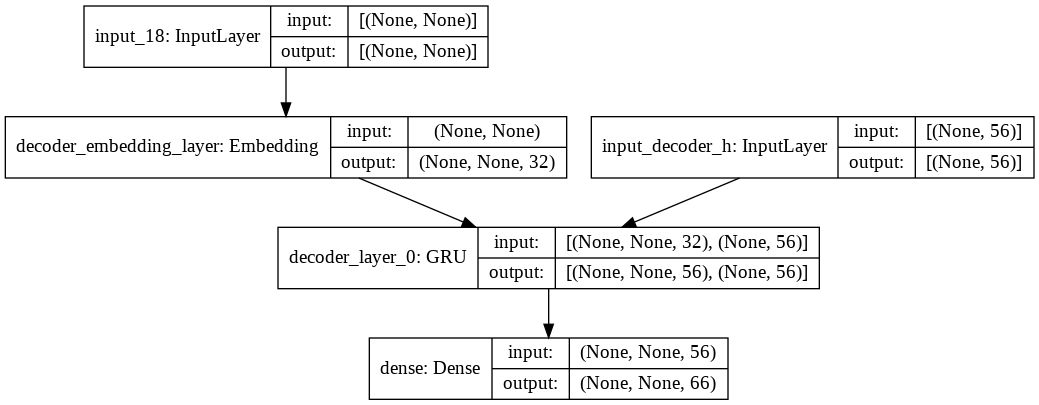

In [108]:
tf.keras.utils.plot_model(decoder_model, to_file = "decoder.png", show_shapes=True)

**VALIDATION ACCURACY**

In [105]:
########################### accuracy calculation ###############################
input_data = val_encoder_input_data #english vectors
output_corpus = val_target_texts #hindi words


acc = machine.calculate_accuracy(output_corpus, input_data, reverse_target_char_index, encoder_model, decoder_model)
print(acc)

0.10142267094997705
